In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy import zeros, newaxis
from scipy import sparse
from scipy.sparse.linalg import spsolve
from joblib import Parallel,delayed
from sklearn.model_selection import cross_val_score
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from keras import utils as np_utils                     
import tensorflow as tf
from sklearn.model_selection import train_test_split  
from keras.layers import Dense,Flatten,Conv1D,MaxPooling1D,Dropout,BatchNormalization,PReLU
from tensorflow.keras import datasets,layers,models
import keras
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from numpy import unique
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import IsolationForest
from keras.wrappers.scikit_learn import KerasClassifier
from imblearn.over_sampling import SMOTE
from keras import backend as K 
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.models import Model
from sklearn.utils import shuffle
from numpy.random import RandomState

np.random.seed(0)

def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L - 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z
#CNNBinaryFinalmodel7
# load in CNN
weightsfile ='CNNBinaryFinalmodel7.h5'
modelfile = 'CNNBinaryFinalmodel7.json'
#CNNRegression_TransferWasteWater
# load model from json
json_file = open(modelfile, 'r')
loaded_model_json = json_file.read()
json_file.close()
base_model = keras.models.model_from_json(loaded_model_json)
base_model.load_weights(weightsfile)
print(base_model.summary())
# remove the last 2 dense FC layers and freeze it
base_model.pop()
base_model.pop()
base_model.trainable = False

#new_layer = Dense(1, activation='sigmoid')

inp = base_model.input

last = base_model.layers[-1].output
#x = Flatten()(last)
#x = Dense(1000, activation='relu', name='fc1')(x)
#x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid', name='predictions')(last)

model2 = Model(inp, x)

#base_model.layers[0].trainable = False
#base_model.layers[1].trainable = False
#base_model.layers[2].trainable = False
#model2.layers[0].trainable = True
model2.layers[1].trainable = True
model2.layers[2].trainable = True
model2.layers[3].trainable = True
model2.layers[4].trainable = True
model2.layers[5].trainable = True
model2.layers[6].trainable = True
model2.layers[7].trainable = False
model2.layers[8].trainable = False
model2.layers[9].trainable = False
model2.layers[10].trainable = False
model2.layers[11].trainable = False
model2.layers[12].trainable = False
model2.layers[13].trainable = False
model2.layers[14].trainable = False
#model2.layers[15].trainable = True

print(model2.summary())

fnames=sorted(glob('/Users/hongwei/Desktop/MachineLearningdata/20220401_Wastewater_400/*'))
files=[np.loadtxt(f) for f in fnames]
map=[f[:,3] for f in files]
map=[np.reshape(m,(-1,1011)) for m in map]
map_full = np.concatenate([m[:,:] for m in map],axis=0)

y = np.concatenate([np.repeat(i, len(m)) for i, m in enumerate(map)], axis=0)
map_full= savgol_filter(map_full, 11, 3, axis=0)
back = Parallel(n_jobs=8)(delayed(baseline_als)(j, 100000, 0.001) for j in map_full)
map_full= np.subtract(map_full, back)
map_full= np.reshape(map_full, (-1, 1011))
#X= minmax_scale(map_full, axis=1)
divide=map_full[:,999:1000]
X=map_full/divide

x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=0.5,stratify=y,shuffle=True)
x_val, x_test, y_val, y_test=train_test_split(x_test,y_test,test_size=0.8,stratify=y_test,shuffle=True)

print(x_train.shape)
print(x_val.shape)

pca = PCA(n_components=22)
pca.fit(x_train)
x_train= pca.transform(x_train)
x_val= pca.transform(x_val)
x_test= pca.transform(x_test)

x_train_cnn= np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_val_cnn= np.reshape(x_val, (x_val.shape[0], x_val.shape[1],1))
x_test_cnn= np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

base_learning_rate = 0.001
#sparse_categorical
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss='binary_crossentropy',metrics=['accuracy'])

finetune_history=model2.fit(x_train_cnn, y_train,epochs=500,validation_data=(x_val_cnn,y_val))

Using TensorFlow backend.
2022-09-24 09:08:27.691472: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-24 09:08:27.692906: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 22, 22)            176       
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 22)            88        
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 22)            3410      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 22)            88        
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 22)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 44)           

Epoch 23/500
800/800 [==============================] - 0s 588us/step - loss: 0.0981 - accuracy: 0.9675 - val_loss: 0.0689 - val_accuracy: 0.9750
Epoch 24/500
800/800 [==============================] - 0s 575us/step - loss: 0.0921 - accuracy: 0.9600 - val_loss: 0.0656 - val_accuracy: 0.9812
Epoch 25/500
800/800 [==============================] - 0s 589us/step - loss: 0.0866 - accuracy: 0.9700 - val_loss: 0.0613 - val_accuracy: 0.9812
Epoch 26/500
800/800 [==============================] - 0s 572us/step - loss: 0.0621 - accuracy: 0.9787 - val_loss: 0.0615 - val_accuracy: 0.9812
Epoch 27/500
800/800 [==============================] - 0s 584us/step - loss: 0.0728 - accuracy: 0.9750 - val_loss: 0.0616 - val_accuracy: 0.9812
Epoch 28/500
800/800 [==============================] - 0s 623us/step - loss: 0.0687 - accuracy: 0.9750 - val_loss: 0.0624 - val_accuracy: 0.9812
Epoch 29/500
800/800 [==============================] - 0s 601us/step - loss: 0.0762 - accuracy: 0.9675 - val_loss: 0.0559 -

800/800 [==============================] - 0s 584us/step - loss: 0.0311 - accuracy: 0.9900 - val_loss: 0.0344 - val_accuracy: 0.9812
Epoch 80/500
800/800 [==============================] - 0s 590us/step - loss: 0.0258 - accuracy: 0.9925 - val_loss: 0.0339 - val_accuracy: 0.9875
Epoch 81/500
800/800 [==============================] - 0s 609us/step - loss: 0.0357 - accuracy: 0.9900 - val_loss: 0.0361 - val_accuracy: 0.9875
Epoch 82/500
800/800 [==============================] - 0s 581us/step - loss: 0.0206 - accuracy: 0.9925 - val_loss: 0.0336 - val_accuracy: 0.9750
Epoch 83/500
800/800 [==============================] - 0s 574us/step - loss: 0.0274 - accuracy: 0.9912 - val_loss: 0.0324 - val_accuracy: 0.9875
Epoch 84/500
800/800 [==============================] - 0s 578us/step - loss: 0.0228 - accuracy: 0.9925 - val_loss: 0.0303 - val_accuracy: 0.9750
Epoch 85/500
800/800 [==============================] - 0s 580us/step - loss: 0.0264 - accuracy: 0.9900 - val_loss: 0.0326 - val_accuracy

Epoch 135/500
800/800 [==============================] - 0s 576us/step - loss: 0.0102 - accuracy: 0.9962 - val_loss: 0.0337 - val_accuracy: 0.9875
Epoch 136/500
800/800 [==============================] - 0s 579us/step - loss: 0.0163 - accuracy: 0.9925 - val_loss: 0.0296 - val_accuracy: 0.9937
Epoch 137/500
800/800 [==============================] - 0s 577us/step - loss: 0.0233 - accuracy: 0.9950 - val_loss: 0.0291 - val_accuracy: 0.9875
Epoch 138/500
800/800 [==============================] - 0s 575us/step - loss: 0.0150 - accuracy: 0.9925 - val_loss: 0.0265 - val_accuracy: 0.9937
Epoch 139/500
800/800 [==============================] - 0s 576us/step - loss: 0.0184 - accuracy: 0.9912 - val_loss: 0.0280 - val_accuracy: 0.9812
Epoch 140/500
800/800 [==============================] - 0s 574us/step - loss: 0.0150 - accuracy: 0.9937 - val_loss: 0.0268 - val_accuracy: 0.9812
Epoch 141/500
800/800 [==============================] - 1s 708us/step - loss: 0.0280 - accuracy: 0.9862 - val_loss: 0

Epoch 191/500
800/800 [==============================] - 0s 581us/step - loss: 0.0090 - accuracy: 0.9962 - val_loss: 0.0375 - val_accuracy: 0.9875
Epoch 192/500
800/800 [==============================] - 0s 583us/step - loss: 0.0235 - accuracy: 0.9912 - val_loss: 0.0326 - val_accuracy: 0.9937
Epoch 193/500
800/800 [==============================] - 0s 578us/step - loss: 0.0068 - accuracy: 0.9987 - val_loss: 0.0346 - val_accuracy: 0.9937
Epoch 194/500
800/800 [==============================] - 0s 581us/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0356 - val_accuracy: 0.9875
Epoch 195/500
800/800 [==============================] - 0s 584us/step - loss: 0.0125 - accuracy: 0.9950 - val_loss: 0.0373 - val_accuracy: 0.9875
Epoch 196/500
800/800 [==============================] - 0s 585us/step - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.0359 - val_accuracy: 0.9875
Epoch 197/500
800/800 [==============================] - 0s 583us/step - loss: 0.0098 - accuracy: 0.9975 - val_loss: 0

Epoch 247/500
800/800 [==============================] - 0s 581us/step - loss: 0.0149 - accuracy: 0.9950 - val_loss: 0.0359 - val_accuracy: 0.9875
Epoch 248/500
800/800 [==============================] - 0s 585us/step - loss: 0.0116 - accuracy: 0.9937 - val_loss: 0.0396 - val_accuracy: 0.9812
Epoch 249/500
800/800 [==============================] - 0s 599us/step - loss: 0.0253 - accuracy: 0.9912 - val_loss: 0.0339 - val_accuracy: 0.9812
Epoch 250/500
800/800 [==============================] - 0s 618us/step - loss: 0.0053 - accuracy: 0.9975 - val_loss: 0.0328 - val_accuracy: 0.9875
Epoch 251/500
800/800 [==============================] - 0s 597us/step - loss: 0.0156 - accuracy: 0.9950 - val_loss: 0.0293 - val_accuracy: 0.9812
Epoch 252/500
800/800 [==============================] - 0s 585us/step - loss: 0.0341 - accuracy: 0.9875 - val_loss: 0.0252 - val_accuracy: 0.9812
Epoch 253/500
800/800 [==============================] - 0s 588us/step - loss: 0.0056 - accuracy: 0.9975 - val_loss: 0

Epoch 303/500
800/800 [==============================] - 0s 580us/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.0297 - val_accuracy: 0.9812
Epoch 304/500
800/800 [==============================] - 0s 581us/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0295 - val_accuracy: 0.9812
Epoch 305/500
800/800 [==============================] - 0s 579us/step - loss: 0.0055 - accuracy: 0.9975 - val_loss: 0.0374 - val_accuracy: 0.9750
Epoch 306/500
800/800 [==============================] - 0s 581us/step - loss: 0.0089 - accuracy: 0.9962 - val_loss: 0.0343 - val_accuracy: 0.9750
Epoch 307/500
800/800 [==============================] - 1s 632us/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0342 - val_accuracy: 0.9750
Epoch 308/500
800/800 [==============================] - 0s 584us/step - loss: 0.0089 - accuracy: 0.9962 - val_loss: 0.0398 - val_accuracy: 0.9750
Epoch 309/500
800/800 [==============================] - 0s 584us/step - loss: 0.0106 - accuracy: 0.9950 - val_loss: 0

Epoch 359/500
800/800 [==============================] - 0s 581us/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.0478 - val_accuracy: 0.9750
Epoch 360/500
800/800 [==============================] - 0s 581us/step - loss: 0.0094 - accuracy: 0.9987 - val_loss: 0.0416 - val_accuracy: 0.9750
Epoch 361/500
800/800 [==============================] - 0s 582us/step - loss: 0.0070 - accuracy: 0.9975 - val_loss: 0.0402 - val_accuracy: 0.9688
Epoch 362/500
800/800 [==============================] - 0s 591us/step - loss: 0.0087 - accuracy: 0.9975 - val_loss: 0.0427 - val_accuracy: 0.9750
Epoch 363/500
800/800 [==============================] - 0s 610us/step - loss: 0.0114 - accuracy: 0.9950 - val_loss: 0.0362 - val_accuracy: 0.9812
Epoch 364/500
800/800 [==============================] - 0s 610us/step - loss: 0.0085 - accuracy: 0.9975 - val_loss: 0.0371 - val_accuracy: 0.9812
Epoch 365/500
800/800 [==============================] - 0s 587us/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0

Epoch 415/500
800/800 [==============================] - 0s 586us/step - loss: 0.0077 - accuracy: 0.9962 - val_loss: 0.0254 - val_accuracy: 0.9875
Epoch 416/500
800/800 [==============================] - 0s 582us/step - loss: 0.0111 - accuracy: 0.9950 - val_loss: 0.0227 - val_accuracy: 0.9875
Epoch 417/500
800/800 [==============================] - 0s 581us/step - loss: 0.0102 - accuracy: 0.9950 - val_loss: 0.0380 - val_accuracy: 0.9812
Epoch 418/500
800/800 [==============================] - 0s 583us/step - loss: 0.0129 - accuracy: 0.9950 - val_loss: 0.0352 - val_accuracy: 0.9812
Epoch 419/500
800/800 [==============================] - 0s 589us/step - loss: 0.0112 - accuracy: 0.9962 - val_loss: 0.0275 - val_accuracy: 0.9812
Epoch 420/500
800/800 [==============================] - 0s 593us/step - loss: 0.0178 - accuracy: 0.9950 - val_loss: 0.0268 - val_accuracy: 0.9812
Epoch 421/500
800/800 [==============================] - 0s 584us/step - loss: 0.0073 - accuracy: 0.9975 - val_loss: 0

Epoch 471/500
800/800 [==============================] - 1s 652us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 0.9688
Epoch 472/500
800/800 [==============================] - 0s 577us/step - loss: 0.0079 - accuracy: 0.9987 - val_loss: 0.0457 - val_accuracy: 0.9688
Epoch 473/500
800/800 [==============================] - 0s 578us/step - loss: 0.0057 - accuracy: 0.9987 - val_loss: 0.0395 - val_accuracy: 0.9750
Epoch 474/500
800/800 [==============================] - 0s 581us/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.0434 - val_accuracy: 0.9750
Epoch 475/500
800/800 [==============================] - 0s 578us/step - loss: 0.0118 - accuracy: 0.9962 - val_loss: 0.0557 - val_accuracy: 0.9750
Epoch 476/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0033 - accuracy: 0.9987 - val_loss: 0.0551 - val_accuracy: 0.9750
Epoch 477/500
800/800 [==============================] - 0s 580us/step - loss: 0.0079 - accuracy: 0.9975 - val_loss: 0.0

In [ ]:
#test on 4 trained class
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,  "{:0.2f}".format(cm[i, j]),
                 horizontalalignment="center",fontsize=20,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#bars = ('C', '0.1','1','100','1000')
#x_pos = np.arange(len(bars))

#y_pred1 = model2.predict_classes(x_test_cnn)
#y_predic=np.argmax(y_pred1,axis=1)

#binary
#X_cleaned= pca.transform(X_cleaned)
#X_cleaned_cnn= np.reshape(X_cleaned, (X_cleaned.shape[0], X_cleaned.shape[1],1))
#y_pred1 = (model2.predict(x_test_cnn) > 0.5).astype("int32")

#multiclass!!
y_pred1=model2.predict(x_test_cnn) 
y_pred1=np.argmax(y_pred1, axis=1)

cn_matrix = confusion_matrix(y_test,y_pred1)
np.set_printoptions(precision=3)

# Plot normalized confusion matrix
class_names=['0.1 \u03bcg/L','1 \u03bcg/L','100 \u03bcg/L','1000 \u03bcg/L']
#plt.figure(figsize=(5,5))
plot_confusion_matrix(cn_matrix, classes=class_names, normalize=True)

In [2]:
fname5=sorted(glob('/Users/hongwei/Desktop/MachineLearningdata/20220401_Wastewater_control/*'))
file5=[np.loadtxt(f) for f in fname5]
map5=[f[:,3] for f in file5]
map5=[np.reshape(m,(-1,1011)) for m in map5]
map_full5= np.concatenate([m[:,:] for m in map5],axis=0)
map_full5=np.array(map_full5)
Y_tes=np.repeat(0,400)
map_full5= savgol_filter(map_full5, 11, 3, axis=1)
back = Parallel(n_jobs=8)(delayed(baseline_als)(j, 100000, 0.001) for j in map_full5)
map_full5= np.subtract(map_full5, back)
map_full5= np.reshape(map_full5, (-1, 1011))

number = map_full5.shape[0]
random = np.random.choice(number, size=400, replace=False)
map_full5=map_full5[random,:]

divide5=map_full5[:,999:1000]
X_tes=map_full5/divide5

clf = IsolationForest(max_samples=1, random_state=4, contamination=0.01)
#identify outliers:
y_pred = clf.fit_predict(X_tes)
#Remove outliers where 1 represent inliers and -1 represent outliers:
X_cleaned, y_cleaned =X_tes[(y_pred != -1), :], Y_tes[(y_pred != -1)]


print(X_cleaned.shape)
print(y_cleaned.shape)

(400, 1011)
(400,)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:453: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:453: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:314: RuntimeWarning: invalid value encountered in less
  is_inlier[self.decision_function(X) < 0] = -1


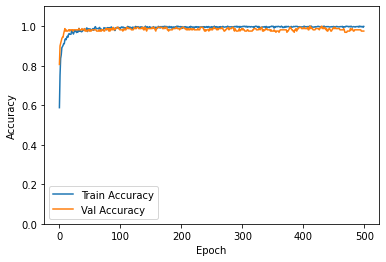

In [3]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
    plt.ylim([0,1.1])
    plt.legend()
    plt.show()

plot_history(finetune_history)

Normalized confusion matrix
[[0.917 0.083]
 [  nan   nan]]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


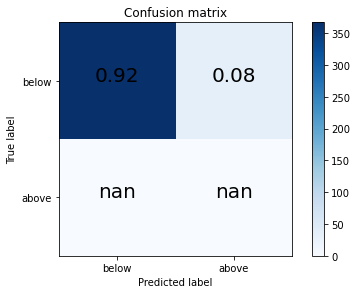

In [4]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,  "{:0.2f}".format(cm[i, j]),
                 horizontalalignment="center",fontsize=20,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#bars = ('C', '0.1','1','100','1000')
#x_pos = np.arange(len(bars))

#y_pred1 = model2.predict_classes(x_test_cnn)
#y_predic=np.argmax(y_pred1,axis=1)

#binary
X_cleaned= pca.transform(X_cleaned)
X_cleaned_cnn= np.reshape(X_cleaned, (X_cleaned.shape[0], X_cleaned.shape[1],1))
y_pred1 = (model2.predict(X_cleaned_cnn) > 0.5).astype("int32")

#multiclass!!
#y_pred1=model2.predict(X_cleaned_cnn) 
#y_pred1=np.argmax(y_pred1, axis=1)

cn_matrix = confusion_matrix(y_cleaned,y_pred1)
np.set_printoptions(precision=3)

# Plot normalized confusion matrix
class_names=['below','above']
#plt.figure(figsize=(5,5))
plot_confusion_matrix(cn_matrix, classes=class_names, normalize=True)

In [ ]:
#plot out embedding 

tsne = TSNE(3, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
cmap = cm.get_cmap('tab20')
num_categories = 1
for lab in range(num_categories):
    indices = test_predictions == lab
    ax.scatter(tsne_proj[indices, 0],
               tsne_proj[indices, 1],
               tsne_proj[indices, 2],
               c=np.array(cmap(lab)).reshape(1, 4),
               label=lab,
               alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [ ]:
#fine tunning 
# Unfreeze the base model
base_model.trainable = True
model2.layers[0].trainable = True
model2.layers[1].trainable = True
model2.layers[2].trainable = True
model2.layers[3].trainable = True
model2.layers[4].trainable = True
model2.layers[5].trainable = True
model2.layers[6].trainable = True
model2.layers[7].trainable = True
model2.layers[8].trainable = True
model2.layers[9].trainable = True
model2.layers[10].trainable = True
model2.layers[11].trainable = True
model2.layers[12].trainable = True
model2.layers[13].trainable = True
model2.layers[14].trainable = True
model2.summary()

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model2.compile(optimizer=keras.optimizers.Adam(1e-5),  
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
finetune_history=model2.fit(x_train_cnn, y_train, epochs=100,validation_data=(x_val_cnn,y_val))



In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
    plt.ylim([0,1])
    plt.legend()
    plt.show()

plot_history(finetune_history)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy import zeros, newaxis
from scipy import sparse
from scipy.sparse.linalg import spsolve
from joblib import Parallel,delayed
from sklearn.model_selection import cross_val_score
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from keras import utils as np_utils                     
import tensorflow as tf
from sklearn.model_selection import train_test_split  
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout,BatchNormalization,PReLU
from tensorflow.keras import datasets, layers, models
import keras
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from numpy import unique
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import IsolationForest
from keras.wrappers.scikit_learn import KerasClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from keras import backend as K 
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import backend as K
from sklearn.ensemble import IsolationForest
from keras.models import Model
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=25,**hfont)
    plt.yticks(tick_marks, classes, fontsize=25,**hfont)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,  "{:0.1f}".format(cm[i, j]),fontsize=15,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",**hfont)

    plt.tight_layout()
    
    plt.ylabel(r'Predicted label ($0.5\times10^X$pM)',fontsize=25,**hfont)
    plt.xlabel(r'True label ($0.5\times10^X$pM)',fontsize=25,**hfont)
    #plt.xlabel(r'Predicted label ($0.5\times10^X$pM)',fontsize=20,**hfont)
hfont = {'fontname':'Helvetica'}

cn_matrix=np.array([[99.6,0.0,9.4,0.3,1.8,2.4,0.0,0.0],
                    [0.1,93.9,3.1,0.0,0.0,0.0,0.0,0.0],
                    [0.2,6.1,87.4,0.0,0.0,0.0,0.0,0.0],
                    [0.0,0.0,0.0,99.1,0.6,0.0,0.0,0.0],
                    [0.1,0.0,0.0,0.6,97.5,0.0,0.0,0.0],
                    [0.0,0.0,0.0,0.0,0.0,97.6,0.0,0.0],
                    [0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0],
                    [0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0]])



class_names = ['C','-2','-1','0','1','2','3','4']
#(\u03bcg/L)
#class_names=['I','II','III','IV']
#plt.figure(figsize=(5, 5))
#plt.title(r'$5\times10^2$ CFU/mL', fontsize=20,**hfont)
#10$^{-2}$
#class_names = [r'Cr$^{6+}$',r'As$^{3+}$']
fig, ax = plt.subplots(figsize=(5, 5))
ax.tick_params(direction='in', length=0, width=1, colors='black')
plot_confusion_matrix(cn_matrix, classes=class_names, normalize=False)
plt.savefig('HM_pnas_as_cm_main.png', dpi=1200,bbox_inches='tight')
#bbox_inches='tight'

In [ ]:
#cr
cn_matrix=np.array([[99.7,0.2,0.0,0.0,0.0,0.0,0.1,0.1],
                    [13.9,85.8, 0.0,0.4,0.0,0.0,0.0,0.0],
                    [0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0],
                    [1.2,0.8,0.0,98.0,0.0,0.0,0.0,0.0],
                    [2.0,0.0,0.0,0.0,97.2,0.4,0.4,0.0],
                    [0.0,0.0,0.0,0.0,0.4,99.6,0.0,0.0],
                    [0.0,0.0,0.0,0.0,0.0,0.8,99.2,0.0],
                    [0.8,0.0,0.0,0.0,0.0,0.0,0.0,99.2]])
cn_matrix=np.array([[98.1,1.3,0.0,0.1,0.1,0.0,0.0,0.3],
                    [1.1,97.5,0.0,1.4,0.0,0.0,0.0,0.0],
                    [0.0,0.1,99.9,0.0,0.0,0.0,0.0,0.0],
                    [0.2,0.7,0.1,99.0,0.0,0.0,0.0,0.0],
                    [0.0,0.0,0.0,0.0,99.4,0.6,0.0,0.0],
                    [0.0,0.0,0.0,0.0,0.5,98.5,0.9,0.0],
                    [0.0,0.0,0.0,0.0,0.6,0.6,98.6,0.1],
                    [0.8,0.0,0.0,0.0,0.0,0.0,0.0,99.2]])

cn_matrix=np.array([[99.8,0.1,0.1,0.1,0.0,0.0,0.1,0.1],
                    [1.2,94.6,4.2,0.0,0.0,0.0,0.0,0.0],
                    [9.4,4.2,86.4,0.0,0.0,0.0,0.0,0.0],
                    [0.4,0.0,0.0,99.6,0.0,0.0,0.0,0.0],
                    [0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0],
                    [0.8,0.0,0.0,0.0,0.0,99.2,0.0,0.0],
                    [0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0],
                    [0.4,0.0,0.0,0.0,0.0,0.0,0.0,99.6]])
cn_matrix=np.array([[98.3,0.1,1.2,0.1,0.0,0.2,0.0,0.0],
                    [0.4,96.4,3.2,0.0,0.0,0.0,0.0,0.0],
                    [0.7,3.4,95.8,0.0,0.0,0.0,0.0,0.0],
                    [0.5,0.0,0.1,99.4,0.0,0.0,0.0,0.0],
                    [0.0,0.0,0.0,0.2,99.8,0.0,0.0,0.0],
                    [0.0,0.0,0.0,0.0,0.0,99.9,0.0,0.1],
                    [0.1,0.0,0.0,0.0,0.6,0.6,99.8,0.1],
                    [0.0,0.0,0.0,0.0,0.0,0.1,0.0,99.9]])


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Fit the model

cf_matrix=np.array([[0.988,0.012],
                    [0.01,0.99]])
sns.heatmap(cf_matrix, annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
from platform import python_version
print(python_version())
fname1=sorted(glob('/Users/hongwei/Desktop/MachineLearningdata/test_0.1_map2/*'))
file1=[np.loadtxt(f) for f in fname1]
map1=[f[:,3] for f in file1]
map1=np.reshape(map1,(-1,1011))
map1= savgol_filter(map1, 11, 3, axis=0)
back = Parallel(n_jobs=8)(delayed(baseline_als)(j, 100000, 0.001) for j in map1)
map1= np.subtract(map1, back)
map1= np.reshape(map1, (-1, 1011))

number1 = map1.shape[0]
random1 = np.random.choice(number1, size=10, replace=False)
map1=map1[random1,:]
y_1=np.repeat(0,10)

#X= minmax_scale(map_full, axis=1)
divide=map1[:,999:1000]
X_1=map1/divide

print(X_1.shape)
print(y_1)

fname2=sorted(glob('/Users/hongwei/Desktop/MachineLearningdata/test_0.1_map3/*'))
file2=[np.loadtxt(f) for f in fname2]
map2=[f[:,3] for f in file2]
map2=np.reshape(map2,(-1,1011))

map2= savgol_filter(map2, 11, 3, axis=0)
back = Parallel(n_jobs=8)(delayed(baseline_als)(j, 100000, 0.001) for j in map2)
map2= np.subtract(map2, back)
map2= np.reshape(map2, (-1, 1011))

number2 = map2.shape[0]
random2 = np.random.choice(number2, size=10, replace=False)
map2=map2[random2,:]
y_2=np.repeat(0,10)

#X= minmax_scale(map_full, axis=1)
divide=map2[:,999:1000]
X_2=map2/divide

print(X_2.shape)
print(y_2)

fname3=sorted(glob('/Users/hongwei/Desktop/MachineLearningdata/test_1_map1/*'))
file3=[np.loadtxt(f) for f in fname3]
map3=[f[:,3] for f in file3]
map3=np.reshape(map3,(-1,1011))

map3= savgol_filter(map3, 11, 3, axis=0)
back = Parallel(n_jobs=8)(delayed(baseline_als)(j, 100000, 0.001) for j in map3)
map3= np.subtract(map3, back)
map3= np.reshape(map3, (-1, 1011))

number3 = map3.shape[0]
random3 = np.random.choice(number3, size=10, replace=False)
map3=map3[random3,:]
y_3=np.repeat(0,10)

#X= minmax_scale(map_full, axis=1)
divide=map3[:,999:1000]
X_3=map3/divide

print(X_3.shape)
print(y_3)

fname4=sorted(glob('/Users/hongwei/Desktop/MachineLearningdata/test_1_map2/*'))
file4=[np.loadtxt(f) for f in fname4]
map4=[f[:,3] for f in file4]
map4=np.reshape(map4,(-1,1011))

map4= savgol_filter(map4, 11, 3, axis=0)
back = Parallel(n_jobs=8)(delayed(baseline_als)(j, 100000, 0.001) for j in map4)
map4= np.subtract(map4, back)
map4= np.reshape(map4, (-1, 1011))

number4 = map4.shape[0]
random4 = np.random.choice(number4, size=10, replace=False)
map4=map4[random4,:]
y_4=np.repeat(0,10)

#X= minmax_scale(map_full, axis=1)
divide=map4[:,999:1000]
X_4=map4/divide

print(X_4.shape)
print(y_4)

fname5=sorted(glob('/Users/hongwei/Desktop/MachineLearningdata/test_1_map3/*'))
file5=[np.loadtxt(f) for f in fname5]
map5=[f[:,3] for f in file5]
map5=np.reshape(map5,(-1,1011))

map5= savgol_filter(map5, 11, 3, axis=0)
back = Parallel(n_jobs=8)(delayed(baseline_als)(j, 100000, 0.001) for j in map5)
map5= np.subtract(map5, back)
map5= np.reshape(map5, (-1, 1011))

number5 = map5.shape[0]
random5 = np.random.choice(number5, size=10, replace=False)
map5=map5[random5,:]
y_5=np.repeat(0,10)

#X= minmax_scale(map_full, axis=1)
divide=map5[:,999:1000]
X_5=map5/divide

print(X_5.shape)
print(y_5)

fname6=sorted(glob('/Users/hongwei/Desktop/MachineLearningdata/test_100_map1/*'))
file6=[np.loadtxt(f) for f in fname6]
map6=[f[:,3] for f in file6]
map6=np.reshape(map6,(-1,1011))

map6= savgol_filter(map6, 11, 3, axis=0)
back = Parallel(n_jobs=8)(delayed(baseline_als)(j, 100000, 0.001) for j in map6)
map6= np.subtract(map6, back)
map6= np.reshape(map6, (-1, 1011))

number6 = map6.shape[0]
random6 = np.random.choice(number6, size=10, replace=False)
map6=map6[random6,:]
y_6=np.repeat(1,10)

#X= minmax_scale(map_full, axis=1)
divide=map6[:,999:1000]
X_6=map6/divide

print(X_6.shape)
print(y_6)

fname7=sorted(glob('/Users/hongwei/Desktop/MachineLearningdata/test_100_map2/*'))
file7=[np.loadtxt(f) for f in fname7]
map7=[f[:,3] for f in file7]
map7=np.reshape(map7,(-1,1011))

map7= savgol_filter(map7, 11, 3, axis=0)
back = Parallel(n_jobs=8)(delayed(baseline_als)(j, 100000, 0.001) for j in map7)
map7= np.subtract(map7, back)
map7= np.reshape(map7, (-1, 1011))

number7 = map7.shape[0]
random7 = np.random.choice(number7, size=10, replace=False)
map7=map7[random7,:]
y_7=np.repeat(1,10)

#X= minmax_scale(map_full, axis=1)
divide=map7[:,999:1000]
X_7=map7/divide

print(X_7.shape)
print(y_7)

fname8=sorted(glob('/Users/hongwei/Desktop/MachineLearningdata/test_100_map3/*'))
file8=[np.loadtxt(f) for f in fname8]
map8=[f[:,3] for f in file8]
map8=np.reshape(map8,(-1,1011))

map8= savgol_filter(map8, 11, 3, axis=0)
back = Parallel(n_jobs=8)(delayed(baseline_als)(j, 100000, 0.001) for j in map8)
map8= np.subtract(map8, back)
map8= np.reshape(map8, (-1, 1011))

number8 = map8.shape[0]
random8 = np.random.choice(number8, size=10, replace=False)
map8=map8[random8,:]
y_8=np.repeat(1,10)

#X= minmax_scale(map_full, axis=1)
divide=map8[:,999:1000]
X_8=map8/divide

print(X_8.shape)
print(y_8)

fname9=sorted(glob('/Users/hongwei/Desktop/MachineLearningdata/test_1000_map1/*'))
file9=[np.loadtxt(f) for f in fname9]
map9=[f[:,3] for f in file9]
map9=np.reshape(map9,(-1,1011))

map9= savgol_filter(map9, 11, 3, axis=0)
back = Parallel(n_jobs=8)(delayed(baseline_als)(j, 100000, 0.001) for j in map9)
map9= np.subtract(map9, back)
map9= np.reshape(map9, (-1, 1011))

number9 = map9.shape[0]
random9 = np.random.choice(number9, size=10, replace=False)
map9=map9[random9,:]
y_9=np.repeat(1,10)

#X= minmax_scale(map_full, axis=1)
divide=map9[:,999:1000]
X_9=map9/divide

print(X_9.shape)
print(y_9)


fname10=sorted(glob('/Users/hongwei/Desktop/MachineLearningdata/test_1000_map2/*'))
file10=[np.loadtxt(f) for f in fname10]
map10=[f[:,3] for f in file10]
map10=np.reshape(map10,(-1,1011))

map10= savgol_filter(map10, 11, 3, axis=0)
back = Parallel(n_jobs=8)(delayed(baseline_als)(j, 100000, 0.001) for j in map10)
map10= np.subtract(map10, back)
map10= np.reshape(map10, (-1, 1011))

number10 = map10.shape[0]
random10 = np.random.choice(number10, size=10, replace=False)
map10=map10[random10,:]
y_10=np.repeat(1,10)

#X= minmax_scale(map_full, axis=1)
divide=map10[:,999:1000]
X_10=map10/divide

print(X_10.shape)
print(y_10)

fname11=sorted(glob('/Users/hongwei/Desktop/MachineLearningdata/test_1000_map3/*'))
file11=[np.loadtxt(f) for f in fname11]
map11=[f[:,3] for f in file11]
map11=np.reshape(map11,(-1,1011))

map11= savgol_filter(map11, 11, 3, axis=0)
back = Parallel(n_jobs=8)(delayed(baseline_als)(j, 100000, 0.001) for j in map11)
map11= np.subtract(map11, back)
map11= np.reshape(map11, (-1, 1011))

number11 = map11.shape[0]
random11 = np.random.choice(number11, size=10, replace=False)
map11=map11[random11,:]
y_11=np.repeat(1,10)

#X= minmax_scale(map_full, axis=1)
divide=map11[:,999:1000]
X_11=map11/divide

print(X_11.shape)
print(y_11)


X=np.concatenate([X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11], axis=0)
y=np.concatenate([y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11], axis=0)


In [ ]:
# save model and architecture to single file
#model.save("CNNmodel.h5")
#print("Saved model to disk")


#For CNN
import math

print(y_preds_1d)

y_exponent=10**y_preds_1d
y_concentration=y_exponent*0.5
print(y_concentration)

print(np.median(y_concentration[0:240]))
print(np.mean(y_concentration[0:240]))
print(np.std(y_concentration[0:240]))

import pandas as pd

df = pd.DataFrame(y_preds_1d)
df.to_csv('PNAS_Cr_CNN_finalwith2nd.csv',index=False)

np.set_printoptions(precision=2)
fnames=sorted(glob('/Users/hongwei/Desktop/MachineLearningdata/031621_Ar_replicate_0.5pM/*'))
files=[np.loadtxt(f) for f in fnames]
map=[f[:,3] for f in files]
map=[np.reshape(m,(-1,1011)) for m in map]
map_full = np.concatenate([m[:,:] for m in map],axis=0)

y = np.concatenate([np.repeat(i, len(m)) for i, m in enumerate(map)], axis=0)
map_full= savgol_filter(map_full, 11, 3, axis=0)
back = Parallel(n_jobs=8)(delayed(baseline_als)(j, 100000, 0.001) for j in map_full)
map_full= np.subtract(map_full, back)
map_full= np.reshape(map_full, (-1, 1011))
#X= minmax_scale(map_full, axis=1)
divide=map_full[:,999:1000]
X=map_full/divide


pca.fit(X)

X_1= pca.transform(X)
X_1 = np.reshape(X_1, (X_1.shape[0], X_1.shape[1],1))

y_pred = model.predict(X_1)

print(np.median(y_pred))
print(np.std(y_pred))


#Plot out figures
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

y_preds_1d=y_predict.flatten()

fig, ax = plt.subplots()

bp=sns.boxplot(x=y_rus,y=y_preds_1d,linewidth=1.3,flierprops = dict(markerfacecolor = 'dodgerblue',markeredgecolor='dodgerblue', markersize = 3,marker='o',),whis=[0.5,99.5])

hfont = {'fontname':'Helvetica'}

labels = ["0","5 fM","5 pM","5 nM","5 \u03bcM","5 mM"]
label = [" ","5 fM","5 pM","5 nM","5 \u03bcM","5 mM"]
ax.tick_params(direction='in', length=8, width=3, colors='black')

ax.xaxis.set_minor_locator(AutoMinorLocator(1))

ax.tick_params(direction='in',which='both', width=1)
ax.tick_params(direction='in',which='minor', length=4)

ax.yaxis.set_minor_locator(AutoMinorLocator(1))

ax.tick_params(which='both', width=1)
ax.tick_params(which='minor', length=4)

ax.set_xticks([0,1,4,7,10,13])
ax.set_yticks([0,1,4,7,10,13])
ax.set_xticklabels(label,fontsize=18,**hfont)
ax.set_yticklabels(labels,fontsize=18,**hfont)
ax.set_xlabel('True Concentrations',fontsize=20,**hfont)
ax.set_ylabel('Predicted Concentrations',fontsize=20,**hfont)

x = np.linspace(0, 14, 13)
plt.plot(x, x + 0, 'black')  # solid green
plt.xlim(-0.5,13.5)
plt.ylim(-0.1,13.5,1)
plt.axhspan(-0.1, 1.8, facecolor='0.9')

plt.show()